In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
#Load MNIST Data
mnist=tf.keras.datasets.mnist
(X_train,y_train),(X_test,y_test)=mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#Scale the inputs in range of (-1,+1) for better training
X_train,X_test=X_train/255.0*2-1 , X_test/255.0*2-1

In [5]:
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (60000, 28, 28)
X_test shape:  (10000, 28, 28)


In [6]:
#Flatten the data
N,H,W=X_train.shape
D=H*W
X_train=X_train.reshape(-1,D)
X_test=X_test.reshape(-1,D)

In [7]:
print ("x_train.shape:" ,X_train.shape)
print ("x_test.shape:" ,X_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [8]:
#Dimentionality of the latent space
latent_dim=100

In [9]:
#Defining the generator model
def build_generator(latent_dim):
   i = Input(shape=(latent_dim,))
   x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
   x = BatchNormalization(momentum=0.7)(x)
   x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
   x = BatchNormalization(momentum=0.7)(x)
   x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
   x = BatchNormalization(momentum=0.7)(x)
   x = Dense(D, activation='tanh')(x)
   model = Model(i, x)
   return model

In [10]:
# Defining the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [11]:
#Compile both models in preparation for training
#Build and compile the discriminator
discriminator=build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])
# Build and compile the combined model
generator = build_generator(latent_dim)

In [12]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [13]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
z.shape

TensorShape([None, 100])

In [15]:
# Pass noise through generator to get an image
img = generator(z)

In [16]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_1')>

In [17]:
#Make sure only the generator is trained
discriminator.trainable=False

In [20]:
#The output is fake,but we label them real!
#Passing he output of generator to the discriminator
fake_pred=discriminator(img)

In [21]:
#Create the combined model object
combined_model_gen=Model(z,fake_pred)

In [22]:
#Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))

In [23]:
#Config
batch_size=64
epochs=10000
sample_period=200
#every sample_period steps generate and save some data

In [24]:
# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
# Store the losses
d_losses = []
g_losses = []
# Create a folder to store generated images
if not os.path.exists('gan_images'): os.makedirs('gan_images')

In [25]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [26]:
### Train the GAN

In [27]:
# Main training loop
for epoch in range(epochs):

########################### ### Train discriminator ### ###########################
# Select a random batch of images
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  real_imgs = X_train[idx]
# Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
# Train the discriminator
# both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


####################### ### Train generator ### #######################
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

# Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)


  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
     d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
epoch: 5101/10000, d_loss: 0.62,      d_acc: 0.68, g_loss: 0.96
2/2 [==============================] - 0s 11ms/step
epoch: 5201/10000, d_loss: 0.64,      d_acc: 0.66, g_loss: 0.91
2/2 [==============================] - 0s 12ms/step
epoch: 5301/10000, d_loss: 0.61,      d_acc: 0.68, g_loss: 1.00
2/2 [==============================] - 0s 12ms/step
epoch: 5401/10000, d_loss: 0.64,      d_acc: 0.65, g_loss: 0.93
2/2 [==============================] - 0s 11ms/step
epoch: 5501/10000, d_loss: 0.63,      d_acc: 0.63, g_loss: 0.88
2/2 [==============================] - 0s 12ms/step
epoch: 5601/10000, d_loss: 0.65,      d_acc: 0.64, g_loss: 0.89
2/2 [==============================] - 0s 15ms/step
epoch: 5701/10000, d_loss: 0.61,      d_acc: 0.68, g_loss: 0.96
2/2 [==============================] - 0s 11ms/step
epoch: 5801/10000, d_loss: 0.69,      d_acc: 0.55, g_loss: 0.86
2/2 [================

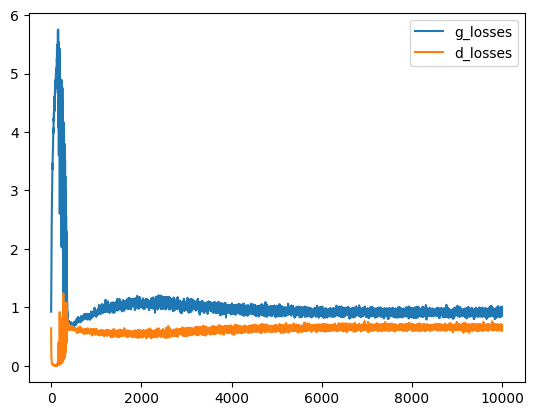

In [28]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [29]:

!ls gan_images


0.png	  1800.png  2600.png  3600.png	4400.png  5400.png  6200.png  7200.png	800.png   9000.png
1000.png  2000.png  2800.png  3800.png	4600.png  5600.png  6400.png  7400.png	8200.png  9200.png
1200.png  200.png   3000.png  4000.png	4800.png  5800.png  6600.png  7600.png	8400.png  9400.png
1400.png  2200.png  3200.png  400.png	5000.png  6000.png  6800.png  7800.png	8600.png  9600.png
1600.png  2400.png  3400.png  4200.png	5200.png  600.png   7000.png  8000.png	8800.png  9800.png


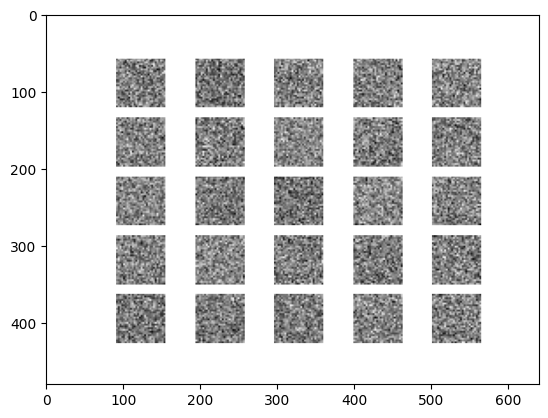

In [30]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

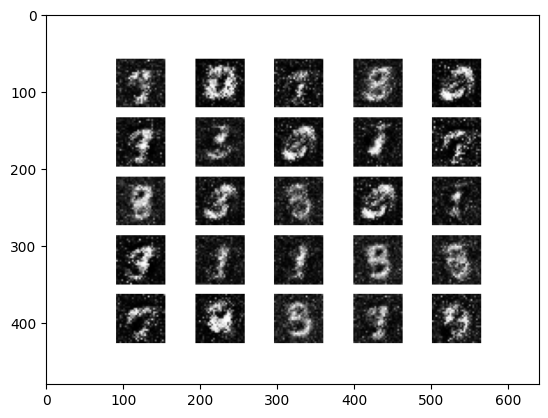

In [31]:
a = imread('gan_images/1000.png')
plt.imshow(a)

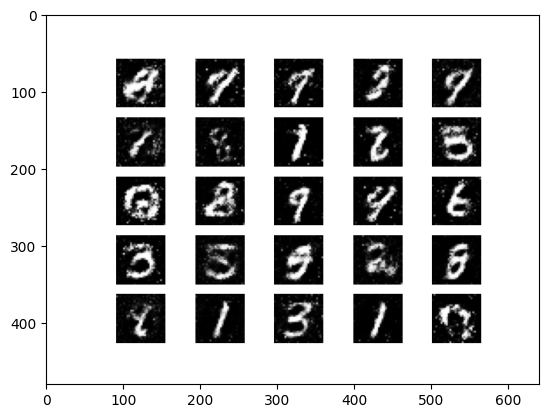

In [34]:
a = imread('gan_images/4000.png')
plt.imshow(a)

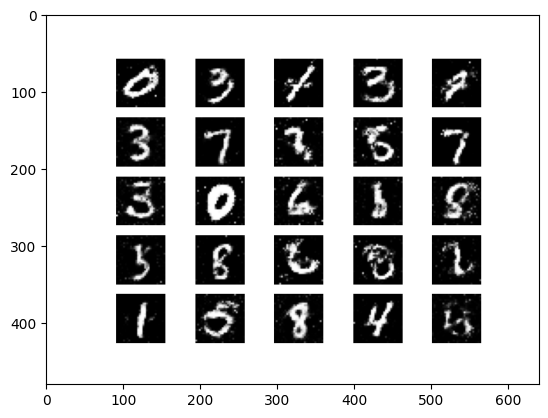

In [40]:
a = imread('gan_images/9000.png')
plt.imshow(a)